In [ ]:
#RUN WITH PYTHON 3.10.0 AND PIP3

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import h5py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-02 12:41:20.022370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.2
GPU available: []


In [8]:
# Load the preprocessed sequences data with class weights and scaler
data_dir = Path("/Volumes/Seizury/HRV/sequences")

def load_sequences_with_metadata(file_path):
    """Load sequences from HDF5 file with class weights and normalization info."""
    with h5py.File(file_path, 'r') as f:
        X = f['X'][:]
        y = f['y'][:]
        train_masks = f['final_masks'][:]
        subjects = f['subjects'][:]
        timestamps = f['timestamps'][:]
        
        # Load class weights if available
        class_weights = None
        if 'class_weights' in f.attrs:
            import json
            class_weights_str = f.attrs['class_weights']
            if isinstance(class_weights_str, bytes):
                class_weights_str = class_weights_str.decode('utf-8')
            class_weights_dict = json.loads(class_weights_str)
            # Convert string keys to integers
            class_weights = {int(k): float(v) for k, v in class_weights_dict.items()}
        
        print(f"Data shape: X={X.shape}, y={y.shape}")
        print(f"Training masks shape: {train_masks.shape}")
        print(f"Subjects: {len(set(subjects))} unique patients")
        if class_weights:
            print(f"Class weights: {class_weights}")
        
        return X, y, train_masks, subjects, timestamps, class_weights

# Load train, val, and test data with metadata
print("Loading training data...")
X_train, y_train, mask_train, subjects_train, timestamps_train, class_weights = load_sequences_with_metadata(data_dir / "train_sequences.h5")

print("\nLoading validation data...")
X_val, y_val, mask_val, subjects_val, timestamps_val, _ = load_sequences_with_metadata(data_dir / "val_sequences.h5")

print("\nLoading test data...")
X_test, y_test, mask_test, subjects_test, timestamps_test, _ = load_sequences_with_metadata(data_dir / "test_sequences.h5")

# Load the feature scaler
import joblib
scaler_path = data_dir / "feature_scaler.joblib"
if scaler_path.exists():
    print(f"\nLoading feature scaler from: {scaler_path}")
    scaler = joblib.load(scaler_path)
    print("Feature scaler loaded successfully")
else:
    print(f"\nWarning: Feature scaler not found at {scaler_path}")
    scaler = None

Loading training data...
Data shape: X=(2574, 60, 22), y=(2574, 60, 4)
Training masks shape: (2574, 60)
Subjects: 13 unique patients
Class weights: {0: 1.3432992854238983, 1: 1.0002183960234226, 2: 1.1403999043732724, 3: 1.0461928139500827}

Loading validation data...
Data shape: X=(457, 60, 22), y=(457, 60, 4)
Training masks shape: (457, 60)
Subjects: 3 unique patients
Class weights: {0: 1.3432992854238983, 1: 1.0002183960234226, 2: 1.1403999043732724, 3: 1.0461928139500827}

Loading test data...
Data shape: X=(323, 60, 22), y=(323, 60, 4)
Training masks shape: (323, 60)
Subjects: 3 unique patients
Class weights: {0: 1.3432992854238983, 1: 1.0002183960234226, 2: 1.1403999043732724, 3: 1.0461928139500827}

Loading feature scaler from: /Volumes/Seizury/HRV/sequences/feature_scaler.joblib
Feature scaler loaded successfully


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
# Analyze class distribution and prepare class weights for training
trainable_y = y_train[mask_train]
trainable_classes = np.argmax(trainable_y, axis=1)
class_counts = np.bincount(trainable_classes, minlength=4)
total_trainable = len(trainable_classes)

print(f"\nDetailed Class Distribution Analysis:")
bin_names = ['0-5min to seizure', '5-30min to seizure', '30-60min to seizure', '>60min (no seizure)']
for i, (name, count) in enumerate(zip(bin_names, class_counts)):
    percentage = count/total_trainable*100
    print(f"  Class {i} ({name}): {count:,} ({percentage:.2f}%)")

# Calculate class imbalance ratios
majority_class_count = max(class_counts)
print(f"\nClass Imbalance Ratios:")
for i, count in enumerate(class_counts):
    if count > 0:
        ratio = majority_class_count / count
        print(f"  Class {i}: 1:{ratio:.1f}")
    else:
        print(f"  Class {i}: No samples")

# Prepare class weights for Keras
if class_weights is None:
    # Calculate class weights manually if not available
    from sklearn.utils.class_weight import compute_class_weight
    unique_classes = np.unique(trainable_classes)
    class_weights_array = compute_class_weight('balanced', classes=unique_classes, y=trainable_classes)
    class_weights = {int(cls): float(weight) for cls, weight in zip(unique_classes, class_weights_array)}
    print(f"Computed class weights: {class_weights}")
else:
    print(f"Using saved class weights: {class_weights}")

# Training mask statistics
train_ratio = mask_train.sum() / mask_train.size
print(f"\nTraining data availability: {train_ratio*100:.1f}% (excludes ictal/post-ictal)")

# Data quality checks
print(f"\nData quality checks:")
print(f"  NaN values in X_train: {np.isnan(X_train).sum()}")
print(f"  Inf values in X_train: {np.isinf(X_train).sum()}")
print(f"  Feature value ranges: [{X_train.min():.3f}, {X_train.max():.3f}]")
print(f"  Zero features (no variation): {np.sum(np.std(X_train.reshape(-1, X_train.shape[-1]), axis=0) == 0)}")


Detailed Class Distribution Analysis:
  Class 0 (0-5min to seizure): 1,775 (1.26%)
  Class 1 (5-30min to seizure): 6,273 (4.45%)
  Class 2 (30-60min to seizure): 8,094 (5.75%)
  Class 3 (>60min (no seizure)): 124,677 (88.54%)

Class Imbalance Ratios:
  Class 0: 1:70.2
  Class 1: 1:19.9
  Class 2: 1:15.4
  Class 3: 1:1.0
Using saved class weights: {0: 1.3432992854238983, 1: 1.0002183960234226, 2: 1.1403999043732724, 3: 1.0461928139500827}

Training data availability: 91.2% (excludes ictal/post-ictal)

Data quality checks:
  NaN values in X_train: 0
  Inf values in X_train: 0
  Feature value ranges: [-2.735, 107.746]
  Zero features (no variation): 0


In [10]:
# Custom loss function that respects training masks
class MaskedCategoricalCrossentropy(tf.keras.losses.Loss):
    """Categorical crossentropy loss that respects training masks."""
    
    def __init__(self, name='masked_categorical_crossentropy'):
        super().__init__(name=name)
        self.cce = CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    
    def call(self, y_true, y_pred):
        # y_true shape: (batch_size, seq_len, 4)
        # y_pred shape: (batch_size, seq_len, 4)
        
        # Calculate loss for each sample and timestep
        sample_loss = self.cce(y_true, y_pred)

        if mask is not None:
            mask = tf.cast(mask, tf.float32)
            sample_loss *= mask  # zero out masked positions
            return tf.reduce_sum(sample_loss) / tf.reduce_sum(mask)  # mean over valid tokens
        else:
            return tf.reduce_mean(sample_loss)

# Custom metric that respects training masks
class MaskedCategoricalAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='masked_categorical_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', shape=(), initializer='zeros')
        self.count = self.add_weight(name='count', shape=(), initializer='zeros')


    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_classes = tf.argmax(y_pred, axis=-1)
        y_true_classes = tf.argmax(y_true, axis=-1)
        matches = tf.cast(tf.equal(y_pred_classes, y_true_classes), tf.float32)

        if sample_weight is not None:
            w = tf.cast(sample_weight, tf.float32)
            if w.shape.rank == 3 and w.shape[-1] == 1:
                w = tf.squeeze(w, axis=-1)
            matches *= w
            self.total.assign_add(tf.reduce_sum(matches))
            self.count.assign_add(tf.reduce_sum(w))
        else:
            self.total.assign_add(tf.reduce_sum(matches))
            self.count.assign_add(tf.cast(tf.size(matches), tf.float32))

    def result(self):
        return tf.math.divide_no_nan(self.total, self.count)

    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)


In [11]:
# Build the LSTM model
def build_lstm_model(input_shape, num_classes=4, class_weights=None):
    """
    Build a baseline LSTM model for per-timestep classification.

    Args:
        input_shape: (sequence_length, n_features)
        num_classes: number of output classes per timestep

    Returns:
        Compiled Keras model (weights untrained)
    """
    model = Sequential([
        Input(shape=input_shape),
        LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
        TimeDistributed(Dense(64, activation='relu')),
        TimeDistributed(Dropout(0.4)),
        TimeDistributed(Dense(32, activation='relu')),
        TimeDistributed(Dropout(0.3)),
        
        # Output layer with softmax
        TimeDistributed(Dense(num_classes, activation='softmax'))
    ])
    return model

In [12]:
import tensorflow as tf
import numpy as np

loss_obj = tf.keras.losses.CategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)

# Enhanced masked training step with class weights
def masked_train_step_weighted(model, X_batch, y_batch, mask_batch, optimizer, class_weights=None):
    mask = tf.cast(mask_batch, tf.float32)
    if mask.shape.rank == 3 and mask.shape[-1] == 1:
        mask = tf.squeeze(mask, axis=-1)

    with tf.GradientTape() as tape:
        y_pred = model(X_batch, training=True)                # (B, T, C)
        per_timestep_loss = loss_obj(y_batch, y_pred)         # (B, T)
        
        # Apply class weights if provided
        if class_weights is not None:
            # Convert class weights dict to tensor
            weights_tensor = tf.constant([class_weights.get(i, 1.0) for i in range(4)], dtype=tf.float32)
            # Get class indices
            y_classes = tf.argmax(y_batch, axis=-1)  # (B, T)
            # Apply weights
            sample_weights = tf.gather(weights_tensor, y_classes)  # (B, T)
            per_timestep_loss = per_timestep_loss * sample_weights
        
        masked_loss = per_timestep_loss * mask
        sum_masked_loss = tf.reduce_sum(masked_loss)
        total_valid = tf.reduce_sum(mask)
        token_loss = sum_masked_loss / tf.maximum(total_valid, 1.0)

        # Add regularization losses if any
        reg_losses = tf.add_n(model.losses) if model.losses else 0.0
        total_loss = token_loss + reg_losses

    grads = tape.gradient(total_loss, model.trainable_variables)
    # Clip gradients to prevent exploding gradients
    grads = [tf.clip_by_norm(g, 1.0) if g is not None else g for g in grads]
    grads_and_vars = [(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None]
    optimizer.apply_gradients(grads_and_vars)

    return total_loss, token_loss

In [13]:
# Enhanced training function with class weights and better monitoring
def train_model_with_masking(model, train_data, val_data, class_weights=None, epochs=50, batch_size=16, 
                        learning_rate=5e-4, patience=10):
    X_train, y_train, mask_train = train_data
    X_val, y_val, mask_val = val_data

    # Use a lower learning rate for more stable training
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)

    history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
    
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Metrics
        train_loss_metric = tf.keras.metrics.Mean()
        train_acc = MaskedCategoricalAccuracy()

        # Shuffle with fixed seed for reproducibility
        np.random.seed(42 + epoch)
        indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices] 
        mask_train_shuffled = mask_train[indices]

        # Training loop with progress tracking
        n_batches = len(X_train) // batch_size + (1 if len(X_train) % batch_size != 0 else 0)
        
        for batch_idx, start in enumerate(range(0, len(X_train), batch_size)):
            end = min(start + batch_size, len(X_train))
            Xb = X_train_shuffled[start:end]
            yb = y_train_shuffled[start:end]
            mb = mask_train_shuffled[start:end]

            total_loss, token_loss = masked_train_step_weighted(model, Xb, yb, mb, optimizer, class_weights)
            train_loss_metric.update_state(token_loss)

            y_pred = model(Xb, training=False)
            train_acc.update_state(yb, y_pred, sample_weight=mb)
            
            # Print progress every 10% of batches
            if (batch_idx + 1) % max(1, n_batches // 10) == 0:
                progress = (batch_idx + 1) / n_batches * 100
                print(f"  Progress: {progress:.0f}% - Batch Loss: {float(token_loss):.4f}", end='\r')

        # Validation loop
        val_loss_metric = tf.keras.metrics.Mean()
        val_acc = MaskedCategoricalAccuracy()

        for start in range(0, len(X_val), batch_size):
            end = min(start + batch_size, len(X_val))
            Xb, yb, mb = X_val[start:end], y_val[start:end], mask_val[start:end]

            y_pred = model(Xb, training=False)
            per_timestep_loss = loss_obj(yb, y_pred)
            
            # Apply class weights to validation loss too
            if class_weights is not None:
                weights_tensor = tf.constant([class_weights.get(i, 1.0) for i in range(4)], dtype=tf.float32)
                y_classes = tf.argmax(yb, axis=-1)
                sample_weights = tf.gather(weights_tensor, y_classes)
                per_timestep_loss = per_timestep_loss * sample_weights
            
            masked_loss = per_timestep_loss * tf.cast(mb, tf.float32)
            sum_masked_loss = tf.reduce_sum(masked_loss)
            total_valid = tf.reduce_sum(tf.cast(mb, tf.float32))
            token_loss = sum_masked_loss / tf.maximum(total_valid, 1.0)
            val_loss_metric.update_state(token_loss)

            val_acc.update_state(yb, y_pred, sample_weight=mb)

        # Collect metrics
        train_loss = float(train_loss_metric.result())
        train_accuracy = float(train_acc.result())
        val_loss = float(val_loss_metric.result())
        val_accuracy = float(val_acc.result())

        history["loss"].append(train_loss)
        history["accuracy"].append(train_accuracy)
        history["val_loss"].append(val_loss)
        history["val_accuracy"].append(val_accuracy)

        print(f"\nEpoch {epoch+1}: Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print(f"  New best validation loss: {val_loss:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"  Early stopping after {patience} epochs without improvement")
                break

    return history

In [12]:
# Build and train the enhanced model
input_shape = (X_train.shape[1], X_train.shape[2])
print(f"Building enhanced model with input shape: {input_shape}")

# Build enhanced model
model = build_lstm_model(input_shape, num_classes=y_train.shape[-1], class_weights=class_weights)

# Print model summary
model.summary()

# Train with class weights and enhanced parameters
print(f"\nStarting training with class weights: {class_weights}")
history = train_model_with_masking(
    model,
    train_data=(X_train, y_train, mask_train),
    val_data=(X_val, y_val, mask_val),
    class_weights=class_weights,
    epochs=2,
    batch_size=16,  # Smaller batch size for better gradient updates
    learning_rate=5e-4,  # Lower learning rate
    patience=10
)

Building enhanced model with input shape: (60, 22)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 256)        │       285,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 64)         │         4,160 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 60, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 60, 32)         │         2,080 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 60, 32)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 60, 4)          │           132 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 538,596 (2.05 MB)

 Trainable params: 538,596 (2.05 MB)

 Non-trainable params: 0 (0.00 B)


Starting training with class weights: {0: 1.3432992854238983, 1: 1.0002183960234226, 2: 1.1403999043732724, 3: 1.0461928139500827}

Epoch 1/2
  Progress: 99% - Batch Loss: 0.5697
Epoch 1: Loss: 0.7484, Acc: 0.8711, Val Loss: 0.2464, Val Acc: 0.9703
  New best validation loss: 0.2464

Epoch 2/2
  Progress: 99% - Batch Loss: 0.3541
Epoch 2: Loss: 0.5631, Acc: 0.8854, Val Loss: 0.2842, Val Acc: 0.9703


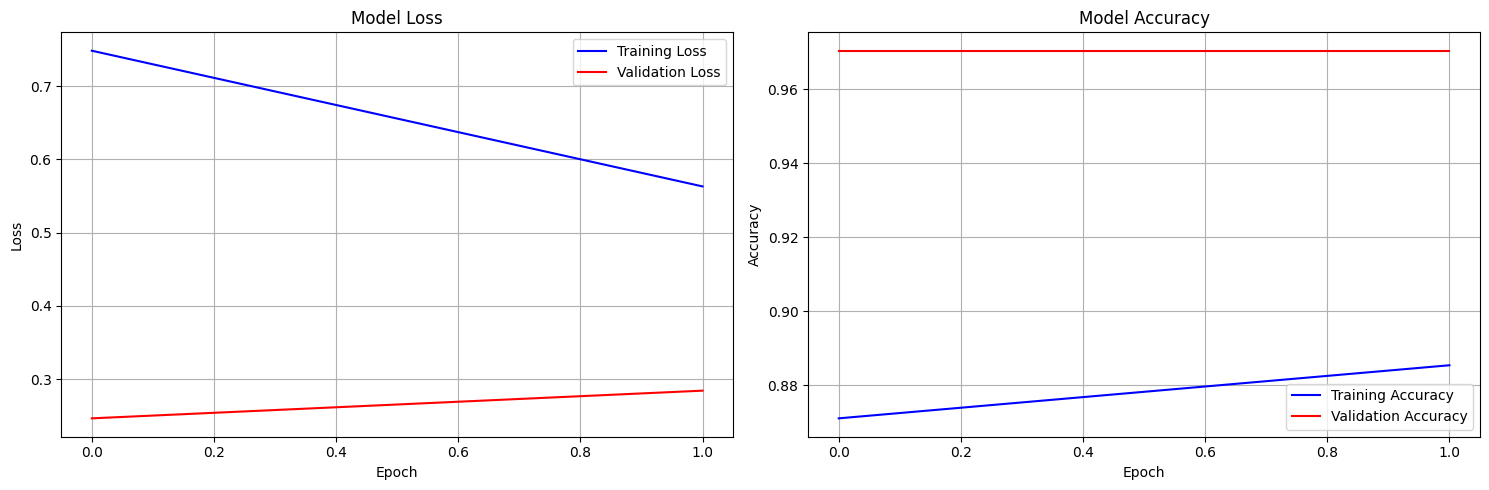

In [13]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['loss'], label='Training Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['accuracy'], label='Training Accuracy', color='blue')
    ax2.plot(history['val_accuracy'], label='Validation Accuracy', color='red')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot results if history exists
if 'history' in locals():
    plot_training_history(history)
else:
    print("No training history available - train the model first")

Evaluating enhanced model performance...
Making predictions...
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step

Evaluation on 18,426 valid predictions

Per-Class Prediction Distribution:
  0-5min: Predicted 0 (0.0%), Actual 130 (0.7%)
  5-30min: Predicted 0 (0.0%), Actual 292 (1.6%)
  30-60min: Predicted 0 (0.0%), Actual 124 (0.7%)
  >60min: Predicted 18,426 (100.0%), Actual 17,880 (97.0%)

Classification Report:
              precision    recall  f1-score   support

      0-5min      0.000     0.000     0.000       130
     5-30min      0.000     0.000     0.000       292
    30-60min      0.000     0.000     0.000       124
      >60min      0.970     1.000     0.985     17880

    accuracy                          0.970     18426
   macro avg      0.243     0.250     0.246     18426
weighted avg      0.942     0.970     0.956     18426



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

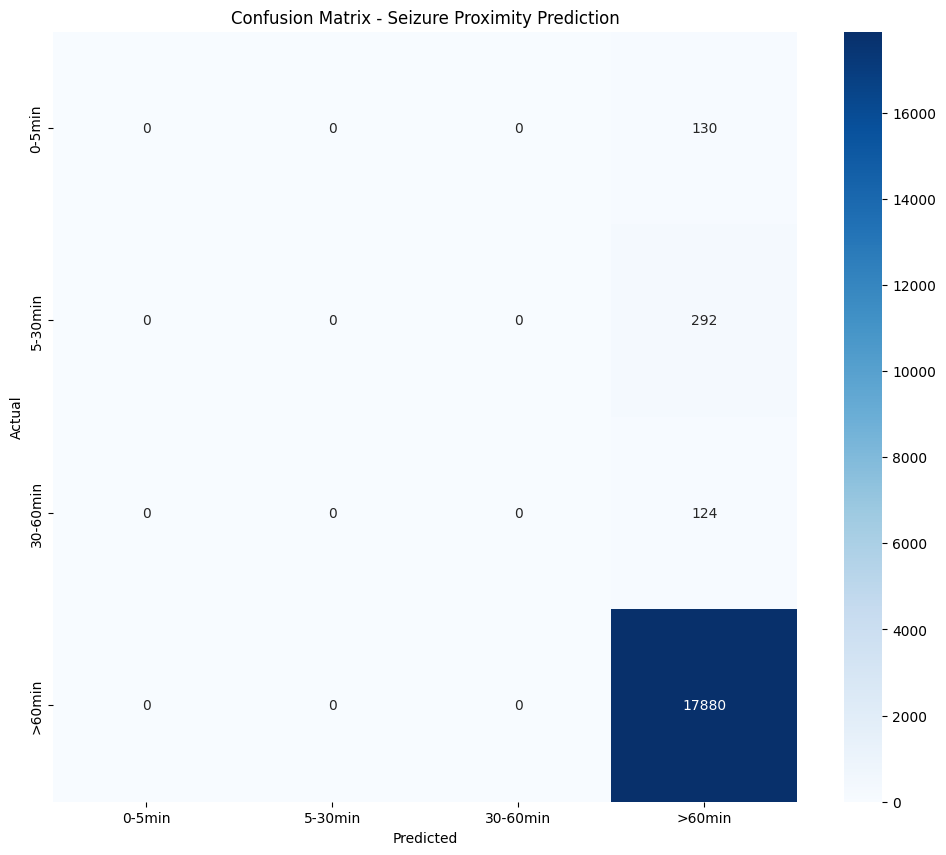


Seizure Detection Performance (Classes 0-1 vs 2-3):
--------------------------------------------------
Precision (PPV): 0.000
Recall (Sensitivity): 0.000
F1-Score: 0.000
Specificity (TNR): 1.000
ROC-AUC: 0.833

Immediate Risk (0-5min) Specific:
Precision: 0.000
Recall: 0.000


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [14]:
# Enhanced evaluation function with detailed metrics
def evaluate_seizure_prediction_enhanced(model, X_test, y_test, mask_test, class_names=None):
    """Enhanced evaluation with detailed medical metrics."""
    
    if class_names is None:
        class_names = ['0-5min', '5-30min', '30-60min', '>60min']
    
    # Make predictions
    print("Making predictions...")
    y_pred = model.predict(X_test, batch_size=32, verbose=1)
    
    # Convert to class predictions
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(y_test, axis=-1)
    
    # Apply mask to get valid predictions only
    valid_mask = mask_test.astype(bool)
    
    # Flatten for analysis
    y_pred_flat = y_pred_classes[valid_mask]
    y_true_flat = y_true_classes[valid_mask]
    y_pred_probs_flat = y_pred[valid_mask]
    
    print(f"\nEvaluation on {len(y_pred_flat):,} valid predictions")
    
    # Per-class analysis
    print("\nPer-Class Prediction Distribution:")
    pred_counts = np.bincount(y_pred_flat, minlength=4)
    true_counts = np.bincount(y_true_flat, minlength=4)
    
    for i, name in enumerate(class_names):
        pred_pct = pred_counts[i] / len(y_pred_flat) * 100
        true_pct = true_counts[i] / len(y_true_flat) * 100
        print(f"  {name}: Predicted {pred_counts[i]:,} ({pred_pct:.1f}%), "
              f"Actual {true_counts[i]:,} ({true_pct:.1f}%)")
    
    # Classification report
    print(f"\nClassification Report:")
    print("="*60)
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_true_flat, y_pred_flat, target_names=class_names, digits=3))
    
    # Confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - Seizure Proximity Prediction')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Medical-specific metrics (focus on seizure classes 0 and 1)
    seizure_classes = [0, 1]  # High-risk classes
    y_true_binary = np.isin(y_true_flat, seizure_classes).astype(int)
    y_pred_binary = np.isin(y_pred_flat, seizure_classes).astype(int)
    
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
    
    print(f"\nSeizure Detection Performance (Classes 0-1 vs 2-3):")
    print("-" * 50)
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    print(f"Precision (PPV): {precision:.3f}")
    print(f"Recall (Sensitivity): {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    # Specificity
    tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))
    fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"Specificity (TNR): {specificity:.3f}")
    
    # ROC-AUC for seizure prediction
    seizure_probs = y_pred_probs_flat[:, seizure_classes].sum(axis=1)
    if len(np.unique(y_true_binary)) == 2:  # Only if both classes present
        auc = roc_auc_score(y_true_binary, seizure_probs)
        print(f"ROC-AUC: {auc:.3f}")
    
    # Immediate risk (Class 0) specific metrics
    class_0_mask = y_true_flat == 0
    if np.sum(class_0_mask) > 0:
        class_0_precision = np.sum((y_pred_flat == 0) & (y_true_flat == 0)) / max(1, np.sum(y_pred_flat == 0))
        class_0_recall = np.sum((y_pred_flat == 0) & (y_true_flat == 0)) / np.sum(y_true_flat == 0)
        print(f"\nImmediate Risk (0-5min) Specific:")
        print(f"Precision: {class_0_precision:.3f}")
        print(f"Recall: {class_0_recall:.3f}")
    
    return {
        'confusion_matrix': cm,
        'y_pred': y_pred_flat,
        'y_true': y_true_flat,
        'y_pred_probs': y_pred_probs_flat,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'specificity': specificity
    }

# Evaluate the enhanced model
if 'model' in locals() and 'X_test' in locals():
    print("Evaluating enhanced model performance...")
    evaluation_results = evaluate_seizure_prediction_enhanced(model, X_test, y_test, mask_test)
else:
    print("Model or test data not available - run previous cells first")

In [ ]:
# Save the trained model
def save_model_and_results(model, history, evaluation_results=None):
    """Save the trained model and training results."""
    
    # Create model directory if it doesn't exist
    model_dir = '/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/• HRV_overlapping/model/saved_models'
    os.makedirs(model_dir, exist_ok=True)
    
    # Save model
    model_path = os.path.join(model_dir, 'seizure_prediction_lstm.h5')
    model.save(model_path)
    print(f"Model saved to: {model_path}")
    
    # Save training history
    history_path = os.path.join(model_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)
    print(f"Training history saved to: {history_path}")
    
    # Save evaluation results if available
    if evaluation_results:
        eval_path = os.path.join(model_dir, 'evaluation_results.pkl')
        with open(eval_path, 'wb') as f:
            pickle.dump(evaluation_results, f)
        print(f"Evaluation results saved to: {eval_path}")
    
    print("\nModel and results saved successfully!")
    return model_path

# Save if model is trained
if 'model' in locals() and 'history' in locals():
    eval_results = evaluation_results if 'evaluation_results' in locals() else None
    model_path = save_model_and_results(model, history, eval_results)
else:
    print("Model not trained yet - run training first")

## Next Steps and Model Improvements

This baseline LSTM model provides a foundation for seizure prediction. Here are potential improvements:

### Architecture Enhancements
- **Attention Mechanisms**: Add attention layers to focus on important time steps
- **Bidirectional LSTM**: Use bidirectional processing for better context
- **Multi-scale Features**: Incorporate different temporal scales (minutes vs hours)
- **Convolutional Layers**: Add 1D convolutions for local pattern detection

### Training Improvements
- **Class Weighting**: Handle class imbalance with weighted loss functions
- **Data Augmentation**: Time series augmentation techniques
- **Advanced Regularization**: Layer normalization, gradient clipping
- **Learning Rate Scheduling**: Adaptive learning rate strategies

### Medical Validation
- **Clinical Metrics**: Sensitivity, specificity for medical applications
- **False Alarm Rate**: Critical for patient acceptance
- **Lead Time Analysis**: How early can seizures be predicted?
- **Patient-specific Models**: Fine-tuning for individual patients

### Deployment Considerations
- **Real-time Processing**: Optimize for continuous monitoring
- **Model Compression**: Reduce size for wearable devices
- **Uncertainty Quantification**: Confidence intervals for predictions
- **Alert System**: Integration with medical monitoring systems